### Attacking the Random Forest with adversarial examples

In [1]:
import pandas as pd

In [ ]:
# ! wget https://raw.githubusercontent.com/neychev/fall19_madmo_adv/master/week09_Adversarial/forest_dataset.csv

In [3]:
all_data = pd.read_csv('forest_dataset.csv')

In [4]:
delayed_data = all_data[int(0.8 * len(all_data)):]
all_data = all_data[:int(0.8 * len(all_data))]

In [5]:
from sklearn.preprocessing import StandardScaler

In [356]:
scaler = StandardScaler()

In [357]:
labels = all_data[all_data.columns[-1]].values - 1
feature_matrix = scaler.fit_transform(all_data[all_data.columns[:-1]].values)

delayed_labels = delayed_data[delayed_data.columns[-1]].values - 1
delayed_feature_matrix = scaler.transform(delayed_data[delayed_data.columns[:-1]].values)

/Users/nexes/miniconda3/envs/py3_research/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nexes/miniconda3/envs/py3_research/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nexes/miniconda3/envs/py3_research/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

Let's fit the Random Forest model on the scaled data

In [29]:
rf = RandomForestClassifier(250, min_samples_split=8, min_samples_leaf=4)

In [30]:
rf.fit(feature_matrix, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
rf.score(feature_matrix, labels)

0.88975

It gets the following scores

In [32]:
print('\n____Train____')
print('Accuracy', accuracy_score(rf.predict(feature_matrix), labels))
print('f1 score', f1_score(rf.predict(feature_matrix), labels, average='macro'))

print('\n____Test____')
print('Accuracy', accuracy_score(rf.predict(delayed_feature_matrix), delayed_labels))
print('f1 score', f1_score(rf.predict(delayed_feature_matrix), delayed_labels, average='macro'))


____Train____
Accuracy 0.88975
f1 score 0.735215405854462

____Test____
Accuracy 0.771
f1 score 0.5088235808348253


Time to get some adversarial examples. We will need those to continue:

In [193]:
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd.gradcheck import zero_gradients

To simulate the random forest with __mimic__ model we will use the probabilities it predicts (actually, we can use either predicted labels or probabilities, but labels carry a bit less information).

In [194]:
new_targets = rf.predict_proba(feature_matrix)

Create some simple model on your own taste

In [195]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__() 
        model = nn.Sequential()
        model.add_module()
        # Your code here
        
        self.model = model
        
    def forward(self, x):
        return self.model(x)

To optimize w.r.t. probabilities (not labels) we need the pure crossentropy function. Let's write it down

In [196]:
# loss_func = torch.nn.CrossEntropyLoss()
def categorical_cross_entropy(y_pred, y_true):
    y_pred = F.log_softmax(y_pred, dim=1)
    crossentropy_score = # Your code here
    return crossentropy_score
loss_func = categorical_cross_entropy

The following function will help us to train the model

In [205]:
def train_nn_on_data(model_constructor, feature_matrix, labels, n_steps=25000, train_on_distribution=False):
    if train_on_distribution:
        loss_func = categorical_cross_entropy
    else:
        loss_func = torch.nn.CrossEntropyLoss()
    
    model = model_constructor()
    opt = torch.optim.Adam(model.parameters())
    
    history = []
    
    for i in range(n_steps):

        # sample 256 random examples
        ix = np.random.randint(0, len(feature_matrix), 256)
        x_batch = torch.tensor(feature_matrix[ix], dtype=torch.float32)
        
        if train_on_distribution:
            y_batch = torch.tensor(new_targets[ix], dtype=torch.float32)
        else:
            y_batch = torch.LongTensor(labels[ix])

        # predict probabilities
        y_predicted = model(x_batch)

        # compute loss, just like before
        loss = loss_func(y_predicted, y_batch)

        # compute gradients
        loss.backward()

        # Adam step
        opt.step()

        # clear gradients
        opt.zero_grad()

        history.append(loss.data.numpy())

        if i % 1000 == 0:
            print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))
            if np.mean(history[-500:]) >= np.mean(history[-2500:-500]):
                for param_group in opt.param_groups:
                    param_group['lr'] *= 0.3
                print('Decreaseing LR, new LR=', opt.param_groups[-1]['lr'])
    return model, history

In [206]:
rf_simulator, rf_simulator_history = train_nn_on_data(
    MyModel,
    feature_matrix,
    new_targets,
    n_steps=10000,
    train_on_distribution=True
)

step #0 | mean loss = 1.941


/Users/nexes/miniconda3/envs/py3_research/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nexes/miniconda3/envs/py3_research/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


step #1000 | mean loss = 0.730
step #2000 | mean loss = 0.728
step #3000 | mean loss = 0.709
step #4000 | mean loss = 0.715
step #5000 | mean loss = 0.712
step #6000 | mean loss = 0.707
step #7000 | mean loss = 0.710
step #8000 | mean loss = 0.703
step #9000 | mean loss = 0.695


In [207]:
indepedent_model, indepedent_model_history = train_nn_on_data(
    MyModel,
    feature_matrix,
    labels, n_steps=10000,
    train_on_distribution=False
)

step #0 | mean loss = 1.918


/Users/nexes/miniconda3/envs/py3_research/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/nexes/miniconda3/envs/py3_research/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


step #1000 | mean loss = 0.497
step #2000 | mean loss = 0.410
step #3000 | mean loss = 0.333
step #4000 | mean loss = 0.285
step #5000 | mean loss = 0.273
step #6000 | mean loss = 0.237
step #7000 | mean loss = 0.209
step #8000 | mean loss = 0.181
step #9000 | mean loss = 0.167


Let's see the model predictions. Following function will help us

In [208]:
def get_model_score(model, feature_matrix, labels, delayed_feature_matrix, delayed_labels, model_name):
    preds_train = model(torch.tensor(feature_matrix, dtype=torch.float32))
    preds_train = preds_train.argmax(dim=1).cpu().numpy()
    
    preds_test = model(torch.tensor(delayed_feature_matrix, dtype=torch.float32))
    preds_test = preds_test.argmax(dim=1).cpu().numpy()
    
    print('_______'+str(model_name)+'_______')
    print('\n____Train____')
    print('Accuracy', accuracy_score(preds_train, labels))
    print('f1 score', f1_score(preds_train, labels, average='macro'))

    print('\n____Test____')
    print('Accuracy', accuracy_score(preds_test, delayed_labels))
    print('f1 score', f1_score(preds_test, delayed_labels, average='macro'))


In [209]:
get_model_score(rf_simulator, feature_matrix, labels, delayed_feature_matrix, delayed_labels, 'rf simulator')

_______rf simulator_______

____Train____
Accuracy 0.83025
f1 score 0.6291907663069585

____Test____
Accuracy 0.77
f1 score 0.5174831439919538


In [210]:
get_model_score(indepedent_model, feature_matrix, labels, delayed_feature_matrix, delayed_labels, 'independent model')

_______independent model_______

____Train____
Accuracy 0.947
f1 score 0.9484183346720437

____Test____
Accuracy 0.7705
f1 score 0.6675925911654333


In [211]:
print('\n____Restored labels on train____')
print('Accuracy', accuracy_score(new_targets.argmax(axis=1), labels))
print('f1 score', f1_score(new_targets.argmax(axis=1), labels, average='macro'))


____Restored labels on train____
Accuracy 0.88975
f1 score 0.735215405854462


From so on we will need only to evaluate our model.

In [216]:
rf_simulator.eval()

MyModel(
  (model): Sequential(
    (l1): Linear(in_features=54, out_features=128, bias=True)
    (a1): ReLU()
    (l2): Linear(in_features=128, out_features=64, bias=True)
    (a2): ReLU()
    (l3): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [312]:
reg_loss = nn.MSELoss()
loss_func = nn.CrossEntropyLoss()
def sneaky_adversarial(model, target, x_target, steps, eta, lambd=0.05):
    """
    model : network object
        neural network instance to use
    target: integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    # Set the goal output
    goal = torch.LongTensor([target])


    x = torch.zeros((1, 54), dtype=torch.float32) #- 0.42
    x.requires_grad_(True)
    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        
        # Your code here
        
        if i % 1000 == 0:
            print('Loss:', loss.data)
        
    return x


In [323]:
reg_loss = nn.MSELoss()
loss_func = nn.CrossEntropyLoss()
def adversarial(model, target, steps, eta):
    """
    model : network object
        neural network instance to use
    target: integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    # Set the goal output
    goal = torch.LongTensor([target]*50)


    # Create a random image to initialize gradient descent with
#     mean, std = 0.1307, 0.3081
    x = torch.from_numpy(np.random.normal(0, 1e-1, (50, 54)).astype(np.float32)).requires_grad_(True)
#     x = torch.zeros((50, 54), dtype=torch.float32) #- 0.42
#     x.requires_grad_(True)
    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        
        # Your code here
        
        if i % 1000 == 0:
            print('Loss:', loss.data)
        
    return x


In [333]:
whole_list = []
for target in range(7):
    a = adversarial(rf_simulator, target, 2000, eta=0.05)
    whole_list.append(a.detach().numpy())

Loss: tensor(1.3238)
Loss: tensor(0.1370)
Loss: tensor(0.8342)
Loss: tensor(0.1434)
Loss: tensor(2.7454)
Loss: tensor(1.2102)
Loss: tensor(3.8259)
Loss: tensor(1.5600)
Loss: tensor(2.7596)
Loss: tensor(0.9905)
Loss: tensor(2.9466)
Loss: tensor(0.9473)
Loss: tensor(2.4212)
Loss: tensor(0.3399)


In [334]:
from sklearn.manifold import TSNE

In [341]:
tsne = TSNE()

In [337]:
simulations = np.concatenate(whole_list, axis=0)

In [338]:
simulations.shape

(350, 54)

In [371]:
from matplotlib import pyplot as plt

In [378]:
import seaborn as sns

In [380]:
import seaborn

In [384]:
from collections import Counter

In [433]:
sim_labels = np.repeat(np.arange(7), 50)
real_labels = np.repeat(np.arange(7), 40)

In [437]:
vis_list = [[] for _ in range(7)]
counter = [0] * 7
for idx, x in enumerate(feature_matrix):
    if counter[labels[idx]] < 40:
        vis_list[labels[idx]].append(x)
        counter[labels[idx]] += 1
        
    if min(counter) == 40:
        break

In [438]:
vis_list = [np.vstack(x) for x in vis_list]
vis_real = np.concatenate(vis_list, axis=0)

In [441]:
all_points = np.concatenate([simulations, vis_real], axis=0)

In [442]:
two_dim_simulations = tsne.fit_transform(all_points)

Here are some nice visualizations

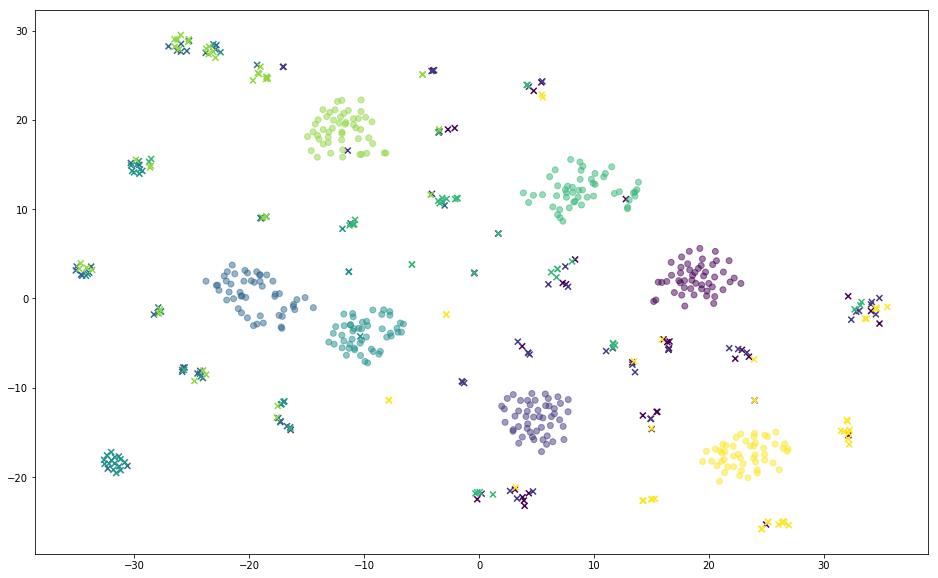

In [445]:
plt.figure(figsize=(16, 10))

plt.scatter(two_dim_simulations[350:, 0], two_dim_simulations[350:, 1], c=real_labels, marker='x')
plt.scatter(two_dim_simulations[:350, 0], two_dim_simulations[:350, 1], c=sim_labels, alpha=0.5)

In [313]:
indepedent_model.eval()
rf_simulator.eval()

MyModel(
  (model): Sequential(
    (l1): Linear(in_features=54, out_features=128, bias=True)
    (a1): ReLU()
    (l2): Linear(in_features=128, out_features=64, bias=True)
    (a2): ReLU()
    (l3): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [314]:
set(delayed_labels)

{0, 1, 2, 3, 4, 5, 6}

In [319]:
def get_adv_probas(a, indepedent_model, rf_simulator, rf):
    print('ind', np.round(F.softmax(indepedent_model(a), dim=1).detach().numpy(), 2))
    print('sim', np.round(F.softmax(rf_simulator(a), dim=1).detach().numpy(), 2))
    print('rf_', np.round(rf.predict_proba(a.detach().numpy()), 2))

In [320]:
for idx in np.random.randint(0, len(delayed_feature_matrix), 10):
    x = delayed_feature_matrix[idx:idx+1]
    real_label = delayed_labels[idx]
    print('Real label: {}, rf predicted {}, \n{}'.format(real_label, rf.predict(x), np.round(rf.predict_proba(x),2)))
    x_tensor = torch.Tensor(x)
    print('ind predicted {},\n{}'.format(indepedent_model(x_tensor).argmax(), np.round(F.softmax(indepedent_model(x_tensor), dim=1).detach().numpy(), 2)))
    print('rf sim predicted {},\n{}'.format(rf_simulator(x_tensor).argmax(), np.round(F.softmax(rf_simulator(x_tensor), dim=1).detach().numpy(), 2)))
        
    print('After ind adv: new target', (real_label+2)%7)
    a = sneaky_adversarial(indepedent_model, (real_label+2)%7, x_tensor, 2000, 0.05, 0.5)
    get_adv_probas(a, indepedent_model, rf_simulator, rf)
    
    print('After sim adv: new target', (real_label+2)%7)
    b = sneaky_adversarial(rf_simulator, (real_label+2)%7, x_tensor, 2000, 0.05, 0.5)
    get_adv_probas(b, indepedent_model, rf_simulator, rf)

    print('_______________________\n_______________________\n')

Real label: 0, rf predicted [0], 
[[0.75 0.22 0.   0.   0.   0.   0.03]]
ind predicted 0,
[[0.96 0.02 0.   0.   0.   0.   0.02]]
rf sim predicted 0,
[[0.67 0.27 0.   0.   0.   0.   0.06]]
After ind adv: new target 2
Loss: tensor(8.9246)
Loss: tensor(0.0792)
ind [[0. 0. 1. 0. 0. 0. 0.]]
sim [[0.22 0.41 0.15 0.01 0.1  0.08 0.01]]
rf_ [[0.13 0.8  0.02 0.   0.04 0.01 0.  ]]
After sim adv: new target 2
Loss: tensor(2.9632)
Loss: tensor(0.2705)
ind [[0. 0. 1. 0. 0. 0. 0.]]
sim [[0.01 0.03 0.94 0.01 0.   0.01 0.  ]]
rf_ [[0.12 0.49 0.28 0.   0.09 0.03 0.  ]]
_______________________
_______________________

Real label: 0, rf predicted [0], 
[[0.79 0.16 0.   0.   0.   0.   0.05]]
ind predicted 0,
[[1. 0. 0. 0. 0. 0. 0.]]
rf sim predicted 0,
[[0.77 0.16 0.   0.   0.   0.   0.07]]
After ind adv: new target 2
Loss: tensor(8.8890)
Loss: tensor(0.1285)
ind [[0. 0. 1. 0. 0. 0. 0.]]
sim [[0.16 0.37 0.2  0.04 0.04 0.17 0.02]]
rf_ [[0.09 0.81 0.02 0.   0.07 0.01 0.  ]]
After sim adv: new target 2
Loss: 